Este dataset multivariado incluye 14 atributos clave relacionados con la salud cardiovascular, como edad, sexo, tipo de dolor torácico, presión arterial, colesterol, y otros factores médicos. Es utilizado principalmente para predecir la presencia de enfermedades cardíacas en pacientes y explorar datos para obtener insights que ayuden a entender mejor la condición. Aunque tiene 76 atributos, la mayoría de los estudios se centran en estos 14 atributos esenciales.
Post de guía: https://towardsdatascience.com/heart-disease-uci-diagnosis-prediction-b1943ee835a7 

En la guía de Towards Data Science, se detalla cómo utilizar el dataset UCI para predecir enfermedades del corazón mediante técnicas de machine learning, incluyendo la limpieza de datos, selección de características, entrenamiento de modelos como la regresión logística, y evaluación con métricas de precisión y ROC.

En este código, se realiza un flujo de trabajo más completo: se imputan datos faltantes, se escalan y codifican variables, se entrenan múltiples modelos (logístico, árbol de decisión, bosque aleatorio, XGBoost) con ajuste de hiperparámetros usando RandomizedSearchCV, y se guardan y cargan los modelos para evaluaciones y comparaciones detalladas, optimizando cada paso del proceso.

Este enfoque utiliza clases en Python, lo que mejora las prácticas de codificación al permitir una estructura modular y reutilizable. Las clases organizan el código en componentes manejables, facilitando la depuración y el mantenimiento del código. Además, permite aplicar principios de buenas prácticas como encapsulación y separación de responsabilidades, lo que hace que el código sea más comprensible y adaptable a futuras modificaciones o ampliaciones del análisis.

Autor: Andre Saul Juarez Castro | https://www.linkedin.com/in/andre-juarez-castro/


Análisis descriptivo

In [2]:
# Importación de librerías necesarias para la implementación del modelo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # Importa RandomizedSearchCV para la búsqueda de hiperparámetros
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel
import joblib
from scipy.stats import uniform, randint  # Importa distribuciones para los hiperparámetros
import warnings
warnings.filterwarnings('ignore', message="X has feature names, but")
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
data = pd.read_csv('heart_dataset.csv')
thal_distribution = data['target'].value_counts()
print(thal_distribution)

target
0    484
1    216
Name: count, dtype: int64


In [4]:
predict_df = pd.read_csv('heart_dataset_inference.csv')
print(predict_df.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')


In [5]:
data.describe()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,626.000000,634.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,55.327476,0.753943,133.247143,248.125714,0.158571,0.487143,145.255714,0.422857,1.298143,1.300000,0.907143,2.417143,0.308571
std,8.658671,1.011478,18.135961,51.079519,0.365537,0.530722,23.659822,0.494366,1.257201,0.611057,1.054294,0.666160,0.462234
min,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.250000,0.000000,120.000000,212.000000,0.000000,0.000000,129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,57.000000,0.000000,130.000000,244.000000,0.000000,0.000000,147.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000
75%,61.000000,2.000000,140.000000,281.000000,0.000000,1.000000,162.000000,1.000000,2.000000,2.000000,2.000000,3.000000,1.000000
max,77.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
data.isnull().sum()

age         74
sex          0
cp          66
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
target       0
dtype: int64

In [7]:
print(data.dtypes)

age         float64
sex          object
cp          float64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


In [9]:
# Mostrar cuantas clases tiene, Si son menos de 8 es una variable categórica
for column in data.columns:
    value_counts = data[column].value_counts(dropna=False)
    if len(value_counts) <= 8:
        print(f"Distribution for {column}:")
        print(value_counts)
        print("\n")

Distribution for sex:
sex
Male      536
Female    164
Name: count, dtype: int64


Distribution for cp:
cp
0.0    378
2.0    136
1.0     77
NaN     66
3.0     43
Name: count, dtype: int64


Distribution for fbs:
fbs
0    589
1    111
Name: count, dtype: int64


Distribution for restecg:
restecg
0    370
1    319
2     11
Name: count, dtype: int64


Distribution for exang:
exang
0    404
1    296
Name: count, dtype: int64


Distribution for slope:
slope
1    376
2    267
0     57
Name: count, dtype: int64


Distribution for ca:
ca
0    333
1    180
2    116
3     61
4     10
Name: count, dtype: int64


Distribution for thal:
thal
3    357
2    283
1     55
0      5
Name: count, dtype: int64


Distribution for target:
target
0    484
1    216
Name: count, dtype: int64




In [31]:
# Example: One-Hot Encoding
dd = pd.get_dummies(data, columns=['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], drop_first=True)
dd

,age,trestbps,chol,thalach,oldpeak,target,sex_Male,cp_1.0,cp_2.0,cp_3.0,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,52.0,125,212,168,1.0,0,True,False,False,False,...,False,False,True,False,True,False,False,False,False,True
1,NaN,140,203,155,3.1,0,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,NaN,145,174,125,2.6,0,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,61.0,148,203,161,0.0,0,True,False,False,False,...,False,False,True,True,False,False,False,False,False,True
4,62.0,138,294,106,1.9,0,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,43.0,132,247,143,0.1,0,True,False,False,False,...,True,True,False,False,False,False,True,False,False,True
696,NaN,110,239,142,1.2,0,True,False,False,False,...,True,True,False,True,False,False,False,False,False,True
697,56.0,134,409,150,1.9,0,False,False,False,False,...,True,True,False,False,True,False,False,False,False,True
698,54.0,120,188,113,1.4,0,True,False,False,False,...,False,True,False,True,False,False,False,False,False,True


    age  trestbps   chol  thalach  oldpeak  target  sex_Male  cp_1.0  cp_2.0  \
0  52.0     125.0  212.0    168.0      1.0       0      True   False   False   
1  54.0     140.0  203.0    155.0      3.1       0      True   False   False   
2  66.4     145.0  174.0    125.0      2.6       0      True   False   False   
3  61.0     148.0  203.0    161.0      0.0       0      True   False   False   
4  62.0     138.0  294.0    106.0      1.9       0     False   False   False   

   cp_3.0  ...  exang_1  slope_1  slope_2   ca_1   ca_2   ca_3   ca_4  thal_1  \
0   False  ...    False    False     True  False   True  False  False   False   
1   False  ...     True    False    False  False  False  False  False   False   
2   False  ...     True    False    False  False  False  False  False   False   
3   False  ...    False    False     True   True  False  False  False   False   
4   False  ...    False     True    False  False  False   True  False   False   

   thal_2  thal_3  
0   False   

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8584\2040928065.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_temp['cp'].dropna(), ax=axes[1, 0], palette='pastel')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8584\2040928065.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['cp'], ax=axes[1, 1], palette='pastel')


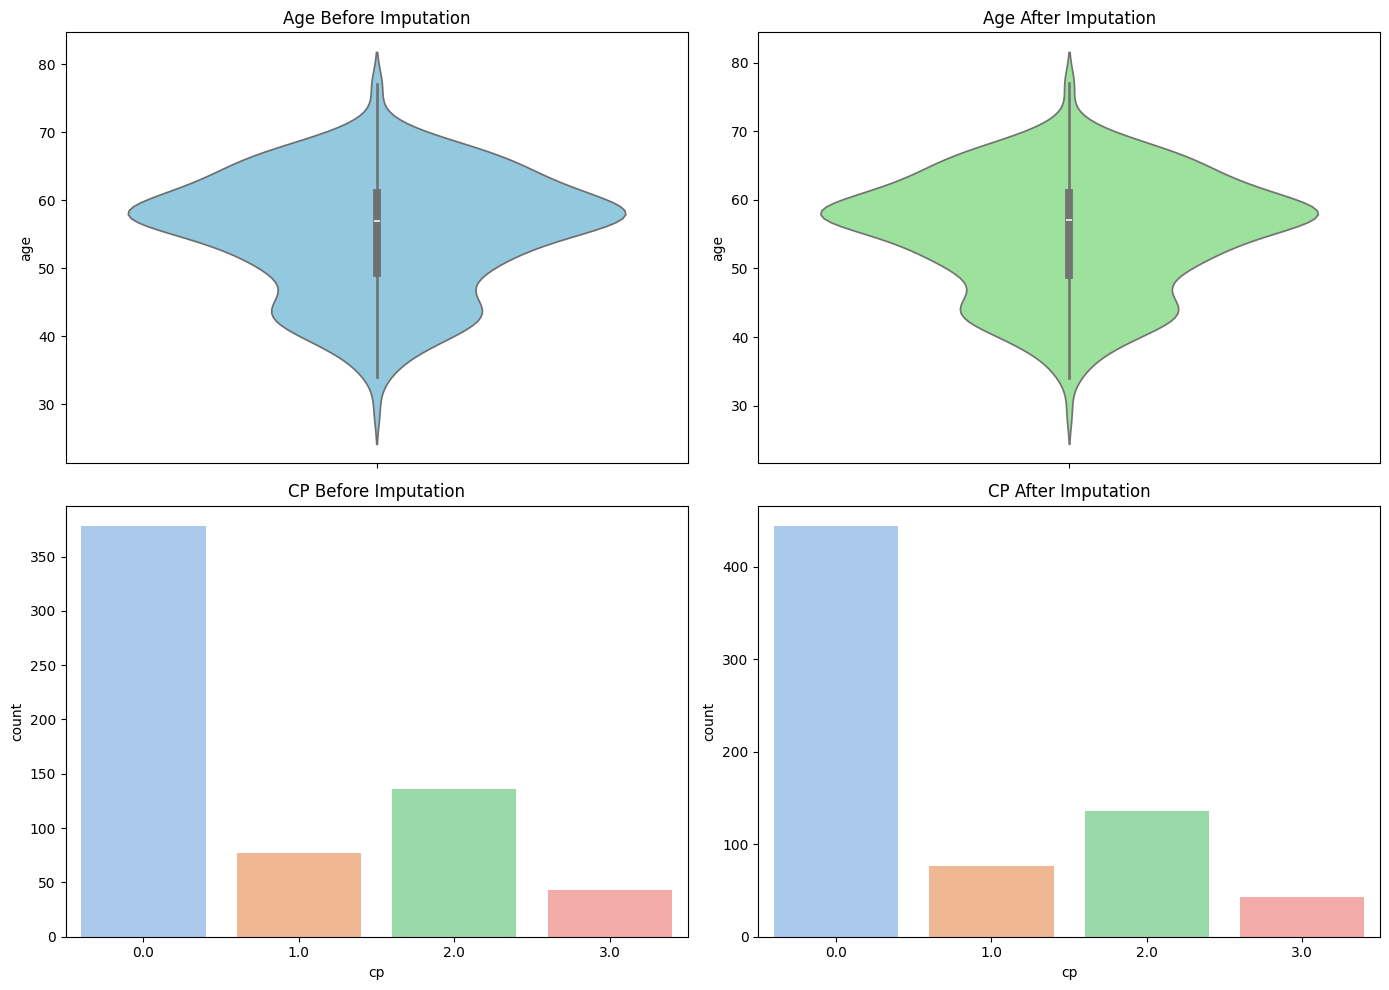

In [36]:
# Importación de librerías necesarias
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Definición de las columnas categóricas y numéricas
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Hacer una copia profunda del DataFrame original para el estado "antes"
data_temp = data.copy(deep=True)

# Imputación de valores faltantes en variables categóricas usando la moda
for column in categorical_cols:
    data[column] = data[column].fillna(data[column].mode()[0])  # Asignación directa sin inplace

# Aplicar la imputación KNN solo en columnas numéricas
imputer = KNNImputer(n_neighbors=5)
data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

# Convertir variables categóricas a numéricas usando One-Hot Encoding
dd = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Mostrar el DataFrame final
print(dd.head())

# Graficar 'age' antes y después de la imputación (numérica)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico de violín para 'age' antes de la imputación
sns.violinplot(data=data_temp['age'].dropna(), ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Age Before Imputation')

# Gráfico de violín para 'age' después de la imputación
sns.violinplot(data=data['age'], ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Age After Imputation')

# Graficar 'cp' antes y después de la imputación (categórica)
sns.countplot(x=data_temp['cp'].dropna(), ax=axes[1, 0], palette='pastel')
axes[1, 0].set_title('CP Before Imputation')

sns.countplot(x=data['cp'], ax=axes[1, 1], palette='pastel')
axes[1, 1].set_title('CP After Imputation')

# Ajustar la disposición de los gráficos
plt.tight_layout()
plt.show()



Implementación del modelo

In [16]:
class Model:
    # Constructor de la clase Model
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame, model_type: str = 'logistic') -> None:
        self.train_df = train_df  # Datos de entrenamiento
        self.test_df = test_df  # Datos de prueba
        self.model_type = model_type  # Tipo de modelo a usar (logístico, árbol de decisión, bosque aleatorio, XGBoost)
        self.model = None
        self.scaler = StandardScaler()  # Inicializa el escalador estándar
        self.features = None
        self.target = 'target'  # Nombre predeterminado de la columna objetivo
        self._initialize_model()  # Inicializa el modelo según el tipo seleccionado

    # Método para inicializar el modelo según el tipo
    def _initialize_model(self) -> None:
        # Inicializa el modelo adecuado basado en model_type
        if self.model_type == 'logistic':
            self.model = LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear")
        elif self.model_type == 'decision_tree':
            self.model = DecisionTreeClassifier()
        elif self.model_type == 'random_forest':
            self.model = RandomForestClassifier(n_estimators=100, random_state=0)
        elif self.model_type == 'xgboost':
            self.model = XGBClassifier(eval_metric='logloss')
        else:
            raise ValueError(f"Unsupported model_type: {self.model_type}")

    # Método para procesar los datos: imputación, escalado y codificación
    def process_data(self, df: pd.DataFrame = None) -> pd.DataFrame:
        if df is None:
            # Procesa los datos de entrenamiento y prueba
            self.train_df = self._process_single_df(self.train_df, fit_scaler=True)
            self.test_df = self._process_single_df(self.test_df, fit_scaler=False)
        else:
            return self._process_single_df(df, fit_scaler=False)

    # Método interno para procesar un solo DataFrame
    def _process_single_df(self, df: pd.DataFrame, fit_scaler: bool = False) -> pd.DataFrame:
        # Columnas categóricas y numéricas
        categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
        numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

        # Imputación de valores faltantes en columnas categóricas con la moda
        for column in categorical_cols:
            if column in df.columns:
                df[column] = df[column].fillna(df[column].mode()[0])

        # Imputación de valores numéricos usando KNN
        imputer = KNNImputer(n_neighbors=4)
        df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

        # Codificación one-hot para las variables categóricas
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

        # Escalado de las columnas numéricas
        if fit_scaler:
            df[numerical_cols] = self.scaler.fit_transform(df[numerical_cols])  # Ajusta y transforma
        else:
            df[numerical_cols] = self.scaler.transform(df[numerical_cols])  # Solo transforma usando el escalador existente

        return df

    # Método para entrenar el modelo
    def train(self) -> None:
        # Excluye la columna objetivo de las características
        self.features = [col for col in self.train_df.columns if col != self.target]

        # Define las características y el objetivo para el entrenamiento
        X_train = self.train_df[self.features].values
        y_train = self.train_df[self.target].values

        if self.model_type == 'xgboost':
            # Definición de la distribución de hiperparámetros para RandomizedSearchCV
            param_dist = {
                'n_estimators': randint(50, 100),  # Número de árboles
                'learning_rate': uniform(0.01, 0.15),  # Tasa de aprendizaje
                'subsample': uniform(0.5, 0.3),  # Submuestreo de los datos
                'reg_lambda': uniform(0.1, 10),  # Regularización L2
                'scale_pos_weight': [2.24]  # Ajuste de la ponderación de clases para el desbalanceo
            }

            # Búsqueda de hiperparámetros con RandomizedSearchCV
            random_search = RandomizedSearchCV(
                estimator=self.model,
                param_distributions=param_dist,
                n_iter=100,  # Número de combinaciones de parámetros probadas
                scoring='accuracy',
                cv=5,  # Validación cruzada de 5 pliegues
                n_jobs=-1,
                verbose=2,
                random_state=0
            )
            random_search.fit(X_train, y_train)

            # Se selecciona el mejor modelo encontrado por RandomizedSearchCV
            self.model = random_search.best_estimator_

            # Guarda los resultados de la validación cruzada
            self.cv_results = {
                "best_params": random_search.best_params_,
                "best_score": random_search.best_score_,
            }

            # Selección de características basadas en la importancia de los modelos XGBoost
            selector = SelectFromModel(self.model, prefit=True)
            X_train_selected = selector.transform(X_train)
            selected_features = np.array(self.features)[selector.get_support()]
            self.features = list(selected_features)
            self.model.fit(X_train_selected, y_train)  # Reentrena el modelo con las características seleccionadas

        elif self.model_type in ['decision_tree', 'random_forest']:
            # Entrena modelos de árbol de decisión o bosque aleatorio
            self.model.fit(X_train, y_train)

            # Selección de características para modelos basados en árboles
            selector = SelectFromModel(self.model, prefit=True)
            X_train_selected = selector.transform(X_train)
            selected_features = np.array(self.features)[selector.get_support()]
            self.features = list(selected_features)
            self.model.fit(X_train_selected, y_train)  # Reentrena el modelo con las características seleccionadas

        else:
            # Entrenamiento para modelos sin ajuste de hiperparámetros ni selección de características
            self.model.fit(X_train, y_train)

    # Método para realizar predicciones con el modelo entrenado
    def predict(self, df: pd.DataFrame = None) -> pd.DataFrame:
        if df is None:
            df = self.test_df
        inference = df.reindex(columns=self.features, fill_value=0).values
        predictions = self.model.predict(inference)

        return pd.Series(predictions, name=self.model_type)

    # Método para evaluar el modelo en los datos de prueba
    def eval(self, df: pd.DataFrame = None) -> dict:
        if df is None:
            df = self.test_df
        X_test = df[self.features]
        y_test = df[self.target]
        predictions = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        report = classification_report(y_test, predictions, output_dict=True)

        # Crear un DataFrame con las métricas de evaluación
        metrics_df = pd.DataFrame({
            'Model': [self.model_type],
            'Test_Accuracy': [accuracy],
            'Precision_0': [report['0']['precision']],
            'Recall_0': [report['0']['recall']],
            'F1-Score_0': [report['0']['f1-score']],
            'Precision_1': [report['1']['precision']],
            'Recall_1': [report['1']['recall']],
            'F1-Score_1': [report['1']['f1-score']],
        })

        # Incluye la precisión de validación cruzada para XGBoost
        if self.model_type == 'xgboost':
            metrics_df['CV_Accuracy'] = self.cv_results['best_score']

        return metrics_df

    # Método para guardar el modelo entrenado y datos asociados en un archivo
    def save(self, path: str) -> None:
        joblib.dump({'model': self.model, 'scaler': self.scaler, 'features': self.features}, path)

    # Método estático para cargar el modelo y datos asociados desde un archivo
    @staticmethod
    def load(path: str):
        saved_dict = joblib.load(path)
        model_instance = Model(pd.DataFrame(), pd.DataFrame())
        model_instance.model = saved_dict['model']
        model_instance.scaler = saved_dict['scaler']
        model_instance.features = saved_dict['features']
        return model_instance

# Función principal que ejecuta el flujo completo del script
def main():
    data_path = 'heart_dataset.csv'  # Ruta al archivo de datos de entrenamiento
    predict_path = 'heart_dataset_inference.csv'  # Ruta al archivo de datos para predicción

    df = pd.read_csv(data_path)  # Carga de los datos
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)  # División en entrenamiento y prueba

    models_to_compare = ['logistic', 'decision_tree', 'random_forest', 'xgboost']  # Tipos de modelos a comparar

    all_metrics = []  # Lista para almacenar métricas de todos los modelos
    all_predictions = pd.DataFrame()  # DataFrame para almacenar todas las predicciones

    for model_type in models_to_compare:
        model = Model(train_df.copy(), test_df.copy(), model_type=model_type)  # Inicializa el modelo
        model.process_data()  # Procesa los datos
        model.train()  # Entrena el modelo

        metrics = model.eval()  # Evalúa el modelo en el conjunto de prueba
        all_metrics.append(metrics)

        model.save(f'{model_type}_model.pkl')  # Guarda el modelo entrenado

        loaded_model = Model.load(f'{model_type}_model.pkl')  # Carga el modelo guardado

        predict_df = pd.read_csv(predict_path)  # Carga los datos de predicción
        predict_df_processed = loaded_model.process_data(predict_df.copy())  # Procesa los datos de predicción

        outcomes = loaded_model.predict(predict_df_processed)  # Realiza las predicciones
        all_predictions = pd.concat([all_predictions, outcomes], axis=1)  # Almacena las predicciones

    final_metrics_df = pd.concat(all_metrics, ignore_index=True)  # Combina todas las métricas de evaluación
    print("\nFinal Evaluation Metrics:\n", final_metrics_df)  # Imprime las métricas de evaluación final
    print("\nFinal Predictions:\n", all_predictions)  # Imprime las predicciones finales

if __name__ == '__main__':
    main()

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Final Evaluation Metrics:
            Model  Test_Accuracy  Precision_0  Recall_0  F1-Score_0  \
0       logistic       0.892857     0.914286  0.941176    0.927536   
1  decision_tree       0.950000     0.935780  1.000000    0.966825   
2  random_forest       0.950000     0.943925  0.990196    0.966507   
3        xgboost       0.850000     0.935484  0.852941    0.892308   

   Precision_1  Recall_1  F1-Score_1  CV_Accuracy  
0     0.828571  0.763158    0.794521          NaN  
1     1.000000  0.815789    0.898551          NaN  
2     0.969697  0.842105    0.901408          NaN  
3     0.680851  0.842105    0.752941     0.964286  

Final Predictions:
     logistic  logistic  logistic  logistic
0          0         0         0         0
1          0         0         0         0
2          0         0         0         1
3          0         0         0         0
4          1         0         0         1
5          0       